In [4]:
# Importar librerías
import pandas as pd
import numpy as np
import json
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [5]:
# Cargar datos y características
processed_data_path = '../../data/processed/final_processed_data.parquet'
features_path = '../../data/processed/final_features.json'

df = pd.read_parquet(processed_data_path)
with open(features_path, 'r') as f:
    final_features = json.load(f)

print("Datos y características cargados.")

Datos y características cargados.


In [6]:
# Preparar datos
target_column = 'precio_mxn'
X = df[final_features]
y = df[target_column]

if X.isnull().sum().sum() > 0 or y.isnull().sum() > 0:
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir pipeline y grid de hiperparámetros
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5],
    'regressor__learning_rate': [0.1, 0.05]
}

# Búsqueda de hiperparámetros
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)

print("Iniciando ajuste de hiperparámetros para Gradient Boosting...")
start_time = time.time()
grid_search.fit(X_train, y_train)
tuning_time = time.time() - start_time
print(f"Ajuste completado en {tuning_time:.2f} segundos.")

print("Mejores parámetros encontrados:", grid_search.best_params_)
print(f"Mejor R² (CV): {grid_search.best_score_:.4f}")

# Evaluar el mejor modelo
best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(X_train)

start_time = time.time()
y_pred_test = best_model.predict(X_test)
prediction_time = time.time() - start_time
print(f"Predicción completada en {prediction_time:.4f} segundos.")

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

train_metrics = evaluate_model(y_train, y_pred_train)
test_metrics = evaluate_model(y_test, y_pred_test)
print(f"R² en prueba (modelo optimizado): {test_metrics['r2']:.4f}")

# Guardar modelo y métricas
model_path = '../../models/gradient_boosting_tuned_pipeline.joblib'
metrics_path = '../../models/gradient_boosting_tuned_metrics.json'
joblib.dump(best_model, model_path)
results = {'train_metrics': train_metrics, 'test_metrics': test_metrics, 'training_time': tuning_time, 'prediction_time': prediction_time, 'best_params': grid_search.best_params_}
with open(metrics_path, 'w') as f:
    json.dump(results, f)

print(f"\nModelo optimizado guardado en: {model_path}")
print(f"Métricas guardadas en: {metrics_path}")

Iniciando ajuste de hiperparámetros para Gradient Boosting...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[CV] END regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.3s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.3s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.3s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.5s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100; total time=   0.4s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.5s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.6s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100; total time=   0.5s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100; total time=   0.4s
[

/var/folders/c7/mdvpp7_n2dj49y88d6cj51kc0000gn/T/ipykernel_18748/935829755.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_10_features, ax=axes[1,1], palette='plasma')


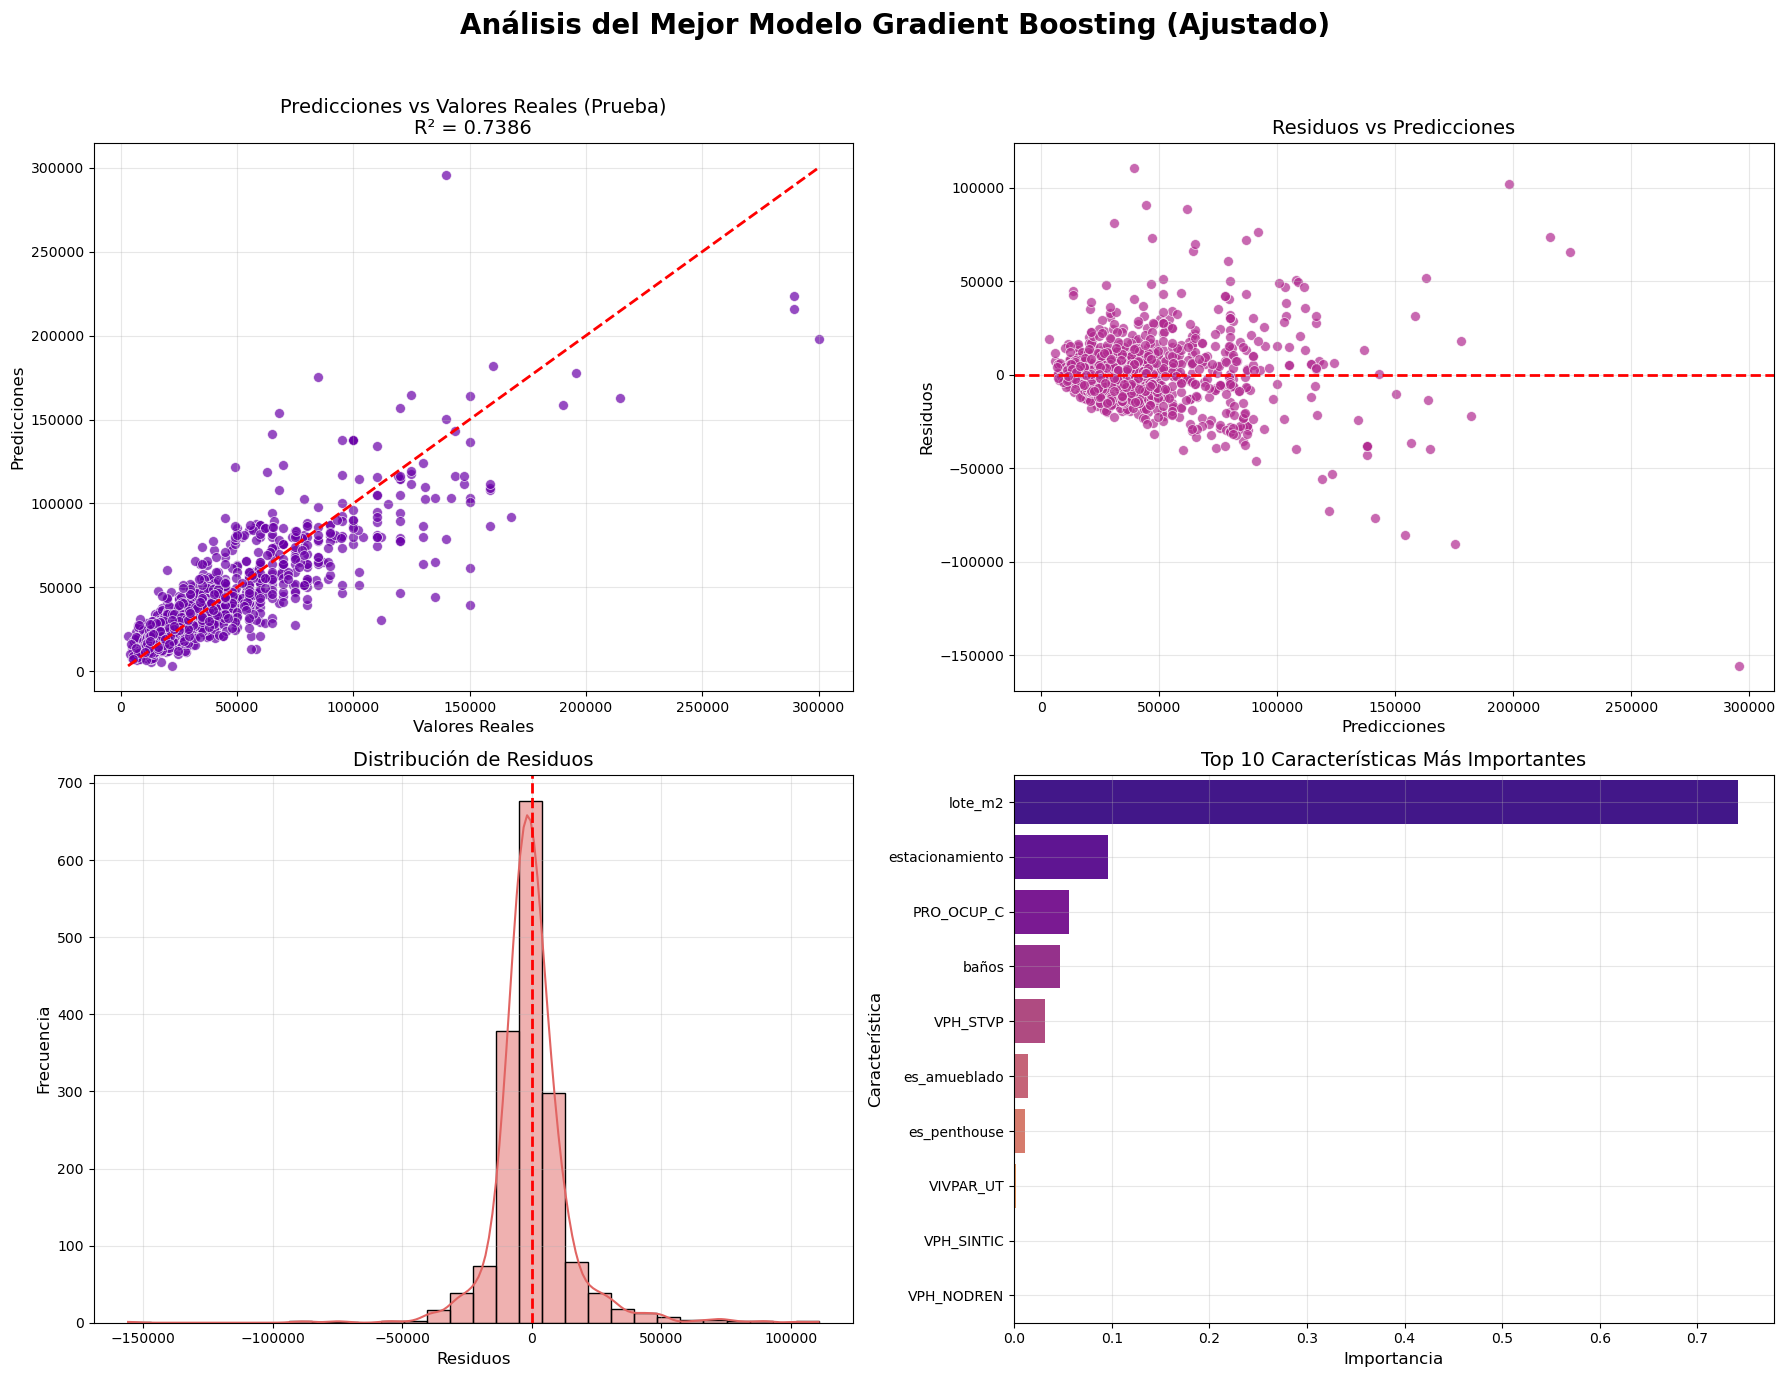

In [7]:
# Visualizaciones del Mejor Modelo
palette = sns.color_palette("plasma", 4)

feature_importance = pd.DataFrame({
    'feature': final_features,
    'importance': best_model.named_steps['regressor'].feature_importances_
}).sort_values('importance', ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Análisis del Mejor Modelo Gradient Boosting (Ajustado)', fontsize=20, weight='bold')

# 1. Predicciones vs Valores Reales
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.7, ax=axes[0,0], color=palette[0], s=50)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
axes[0,0].set_title(f"Predicciones vs Valores Reales (Prueba)\nR² = {test_metrics['r2']:.4f}", fontsize=14)
axes[0,0].set_xlabel("Valores Reales", fontsize=12)
axes[0,0].set_ylabel("Predicciones", fontsize=12)
axes[0,0].grid(True, alpha=0.3)

# 2. Residuos vs Predicciones
residuals_test = y_test - y_pred_test
sns.scatterplot(x=y_pred_test, y=residuals_test, alpha=0.7, ax=axes[0,1], color=palette[1], s=50)
axes[0,1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0,1].set_title("Residuos vs Predicciones", fontsize=14)
axes[0,1].set_xlabel("Predicciones", fontsize=12)
axes[0,1].set_ylabel("Residuos", fontsize=12)
axes[0,1].grid(True, alpha=0.3)

# 3. Distribución de residuos
sns.histplot(residuals_test, bins=30, kde=True, ax=axes[1,0], color=palette[2])
axes[1,0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1,0].set_title("Distribución de Residuos", fontsize=14)
axes[1,0].set_xlabel("Residuos", fontsize=12)
axes[1,0].set_ylabel("Frecuencia", fontsize=12)
axes[1,0].grid(True, alpha=0.3)

# 4. Importancia de características
top_10_features = feature_importance.head(10)
sns.barplot(x='importance', y='feature', data=top_10_features, ax=axes[1,1], palette='plasma')
axes[1,1].set_title("Top 10 Características Más Importantes", fontsize=14)
axes[1,1].set_xlabel("Importancia", fontsize=12)
axes[1,1].set_ylabel("Característica", fontsize=12)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()